In this tutorial, you will learn how to load a segment and visualize the ink labels (if available) that can be used to train an ink detection model with deep learning!

### Getting Started:
First, if you are using Colab, make sure you are on a GPU runtime, otherwise ignore this step!
Then, we need to install and import the `vesuvius` package:

In [2]:
!pip install vesuvius
!vesuvius.accept_terms --yes

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 81.9 MB/s eta 0:00:00:00:010:01
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=4c15d1acc74fadf2998dc56aee728ae4d1d74d4e935a2c888a79aeff8af5c2fa
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree

    ## LICENSE

    The PHerc. 172 (Scroll 5) dataset Â© 2024 by Scroll Prize and the Bodleian Library is licensed under CC BY-NC 4.0: https://creativecommons.org/licenses/by-nc/4.0/legalcode.txt.

    All other Vesuvius Challenge datasets are bound by the following terms:

    By registering for downloads from the EduceLab-Scrolls Dataset and Vesuvius Challenge Discord Server, I agree to license the data from Vesuvius Challenge* under the following licensing terms:
    - I agree that all points

In [3]:
import vesuvius
from vesuvius import Volume

Let us print the list of available segments for Scroll 1:

In [4]:
files = vesuvius.list_files()

segment_ids = list(files['1']['54']['7.91']['segments']) # Select segments from Scroll 1 scanned at 54 keV and 7.91 um resolution

print(f"Number of segments: {len(segment_ids)}")
print(f"Example segment IDs: {segment_ids[:5]}")

Number of segments: 250
Example segment IDs: ['20230503225234', '20230504093154', '20230504094316', '20230504125349', '20230504171956']


Wow, there are many! Let us choose one!
### Data download
We can work with segment `20230827161847` since we know it's interesting.
We start by fetching a "surface volume", a flattened region of micro-CT surrounding this papyrus surface.

In [5]:
segment_id = 20230827161847
segment = Volume(segment_id, normalize=True)

segment.shape(0)

(65, 9163, 5048)

As you have seen in the previous tutorial, the previous command only instantiates an object without downloading the data.
For a segment, the special method `segment.download_inklabels()` is automatically called and the ink labels, if available, are downloaded in the `self.inklabel` variable. If the ink labels are not available `segment.inklabel` will be an empty numpy array filled with 0s.

Let us visualize the layer that is supposed to be on the recto surface (the "front side," with text) of the sheet of papyrus.
The segmentation is a mesh that is meant to follow this recto surface, so we want the middle slice of the surface volume.

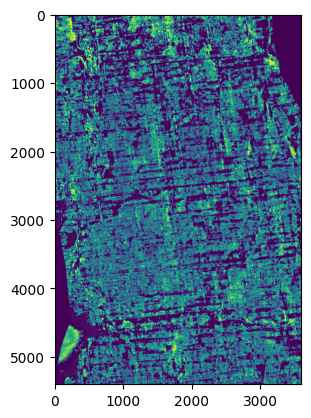

In [6]:
from matplotlib import pyplot as plt

surface_volume_slices = segment.shape(0)[0]
central_slice = surface_volume_slices // 2

plt.imshow(segment[central_slice, 200:5600,1000:4600])

This took a while! But caching is automatically activated in the `Volume` class, so the next iteration should take less time.

We can visualize the ink labels for this segment, focusing just on the upper area, and render them on top of the papyrus sheet:

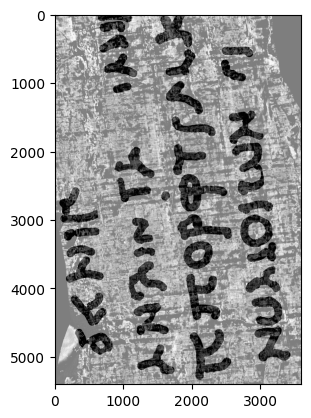

In [7]:
plt.imshow(segment[32,200:5600,1000:4600], cmap='gray')
plt.imshow(segment.inklabel[200:5600,1000:4600], cmap='binary', alpha=0.5)  # Adjust alpha for transparency

# Show the plot
plt.show()

Keep in mind that the papyrus was never physically open and this label was created by inspecting the segment and noticing some "[crackle](https://caseyhandmer.wordpress.com/2023/08/05/reading-ancient-scrolls/)" pattern on the surface. Therefore, the ink labels themselves that we are going to use for training a deep learning model are not perfect. But they are sufficient for detecting ink elsewhere in the scroll!

## Ink Detection

For ink detection we are going to use a stack of surface volume slices centered around the central slice (z=32).

If the central slice follows the recto surface, why do we need more slices? Two reasons: 1) the ink itself is 3D (has some thickness), so we want to capture it, and 2) segmentation is not perfect, so we want to provide some margin for small segmentation errors and still be sure we capture the surface with ink.

In the next cells we are going to define the classes to create a Dataset and an ink detection model.
The dataset will comprise many overlapping square tiles in the coordinates `(Y,X)` with a thickness `Z` and sides of size `TILE_SIZE`.
The amount of overlap is given by `STRIDE`.
Every one of these tiles will have a corresponding 2D ink label associated with it.

In [8]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import autocast
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim
import numpy as np

class VolumetricDataset(Dataset):
    def __init__(self, volume, label, tile_size, stride, validation_zone, valid=False):
        """
        Initialize the dataset with the volume and label.

        Args:
            volume (np.ndarray): The volumetric image of shape (Z, Y, X).
            label (np.ndarray): The 2D label of shape (Y, X).
            tile_size (int): The size of the tiles to extract along the Y and X dimensions.
            stride (int): The stride for extracting tiles along the Y and X dimensions.
        """
        self.volume = volume
        self.label = label
        self.tile_size = tile_size
        self.stride = stride
        self.validation_zone = validation_zone
        self.valid = valid
        self.tiles, self.labels, self.corners = self.extract_tiles()

    def extract_tiles(self):
        """
        Extract 3D tiles from the volume and corresponding 2D labels.

        Returns:
            tiles (list): A list of 3D tiles.
            labels (list): A list of 2D labels corresponding to the tiles.
        """
        Z, Y, X = self.volume.shape
        tiles = []
        labels = []
        corners = []
        # Generate 3D tiles by moving along the Y and X axes
        for y in range(0, Y - self.tile_size + 1, self.stride):
            for x in range(0, X - self.tile_size + 1, self.stride):
                if self.valid is False:
                    if (y + self.tile_size < self.validation_zone[0]) or (y > self.validation_zone[1]):
                        if (x + self.tile_size < self.validation_zone[2]) or (x > self.validation_zone[3]):
                            tile = self.volume[:, y:y + self.tile_size, x:x + self.tile_size]
                            label_tile = self.label[y:y + self.tile_size, x:x + self.tile_size]
                            if np.sum(label_tile)/self.tile_size**2 > 0.05: # at least 5% of ink
                                tiles.append(tile)
                                labels.append(label_tile)
                                corners.append([y,x])
                else:
                    if (y >= self.validation_zone[0]) and (y + self.tile_size <= self.validation_zone[1]):
                        if (x >= self.validation_zone[2]) and (x + self.tile_size <= self.validation_zone[3]):
                            tile = self.volume[:, y:y + self.tile_size, x:x + self.tile_size]
                            label_tile = self.label[y:y + self.tile_size, x:x + self.tile_size]
                            tiles.append(tile)
                            labels.append(label_tile)
                            corners.append([y,x])

        return tiles, labels, corners

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        tile = self.tiles[idx]  # Shape [tile_size, tile_size]
        label = self.labels[idx]  # Shape [tile_size, tile_size]
        corners = self.corners[idx]
        # Convert to torch tensors
        tile = torch.tensor(tile, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
        corners = torch.tensor(corners, dtype=torch.int).unsqueeze(0)
        return tile, label, corners

We create two datasets: one for everything outside the red square, that will be used to train the model, and one for what's inside the red square, that we will use to validate the capability of the model to detect ink.

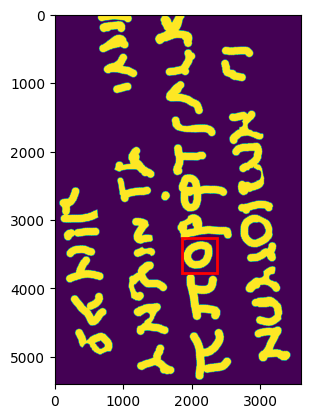

In [9]:
from matplotlib import patches
rect = (1860, 3260, 512, 512)
fig, ax = plt.subplots()
ax.imshow(segment.inklabel[200:5600,1000:4600]/255)
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)
plt.show()

In [10]:
validation_rect = [3260, 3260+512, 1860, 1860+512]

In [11]:
tile_size = 256  # Size of the tile in the YX dimension
stride = 128  # Stride for moving the tile in the YX dimension
batch_size = 2
z_depth = 16 # thickness of the tile
# Create the dataset
dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect)
valid_dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect, valid=True)

# Notice that starting at the layer number 26 and taking a thickness of 16 we are creating a volume around the recto surface (z=32).

# Create the DataLoader for batch processing
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

The UNet model is a well known architecture for classification and segmentation of images. A 3D variant also exists, but it is too complex for this tutorial.
We are going to slightly modify UNet by introducing a convolutional layer at the beginning, followed by a max over the z-axis. This sequence of operation will allow us to intelligently convert a 3D tile (that has a thickness in the z-axis) in a 2D image by retaining the information necessary to detect the ink.
Then, the freshly created 2D image will be feeded to a classical UNet architecture to and ink will be detected pixel by pixel.

In [12]:

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Z Convolution (Vertical Convolution along the depth dimension)
        self.conv_z = nn.Conv3d(in_channels=1, out_channels=64, kernel_size=(3, 1, 1), padding=(1, 0, 0))

        # Contracting path
        self.enc_conv1 = self.double_conv(64, 64)
        self.enc_conv2 = self.double_conv(64, 128)
        self.enc_conv3 = self.double_conv(128, 256)
        self.enc_conv4 = self.double_conv(256, 512)
        self.enc_conv5 = self.double_conv(512, 1024)

        # Expansive path
        self.up_trans1 = self.up_conv(1024, 512)
        self.dec_conv1 = self.double_conv(1024, 512)
        self.up_trans2 = self.up_conv(512, 256)
        self.dec_conv2 = self.double_conv(512, 256)
        self.up_trans3 = self.up_conv(256, 128)
        self.dec_conv3 = self.double_conv(256, 128)
        self.up_trans4 = self.up_conv(128, 64)
        self.dec_conv4 = self.double_conv(128, 64)

        # Final output
        self.out_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Apply the Z convolution
        x = self.conv_z(x)  # [batch_size, 64, depth, height, width]

        # Aggregate the depth dimension using max pooling or average pooling
        x, _ = torch.max(x, dim=2)  # Choose max or torch.mean(x, dim=2) for average pooling

        # Encoder
        x1 = self.enc_conv1(x)
        x2 = self.enc_conv2(F.max_pool2d(x1, kernel_size=2))
        x3 = self.enc_conv3(F.max_pool2d(x2, kernel_size=2))
        x4 = self.enc_conv4(F.max_pool2d(x3, kernel_size=2))
        x5 = self.enc_conv5(F.max_pool2d(x4, kernel_size=2))

        # Decoder
        x = self.up_trans1(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.dec_conv1(x)

        x = self.up_trans2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec_conv2(x)

        x = self.up_trans3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec_conv3(x)

        x = self.up_trans4(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec_conv4(x)

        x = self.out_conv(x)

        return x

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def up_conv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)


# This function initializes the weights in an intelligent way
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv3d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.ConvTranspose2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm3d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

In [40]:
class FiLMLayer(nn.Module):
    def __init__(self, embedding_dim, output_channels):
        super().__init__()
        self.gamma = nn.Linear(embedding_dim, output_channels)  # Scaling parameters
        self.beta = nn.Linear(embedding_dim, output_channels)   # Shifting parameters

    def forward(self, x, embedding):
        gamma = self.gamma(embedding)[:, :, None, None]  # Shape [B, C, 1, 1]
        beta = self.beta(embedding)[:, :, None, None]
        return gamma * x + beta  # Modulate features

In [41]:
class DoubleConvWithFiLM(nn.Module):
    def __init__(self, in_channels, out_channels, embedding_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.film1 = FiLMLayer(embedding_dim, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.film2 = FiLMLayer(embedding_dim, out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, embedding):
        x = self.conv1(x)
        x = self.film1(x, embedding)  # Apply FiLM after 1st conv
        x = self.relu(x)
        x = self.conv2(x)
        x = self.film2(x, embedding)  # Apply FiLM after 2nd conv
        x = self.relu(x)
        return x

In [46]:
class UNet(nn.Module):
    def __init__(self, embedding_dim):
        super(UNet, self).__init__()
        # Z Convolution (3D)
        self.conv_z = nn.Conv3d(1, 64, kernel_size=(3, 1, 1), padding=(1, 0, 0))

        # Encoder (now uses FiLM)
        self.enc_conv1 = DoubleConvWithFiLM(64, 64, embedding_dim)
        self.enc_conv2 = DoubleConvWithFiLM(64, 128, embedding_dim)
        self.enc_conv3 = DoubleConvWithFiLM(128, 256, embedding_dim)
        
        self.up_trans3 = self.up_conv(256, 128)
        self.dec_conv3 = DoubleConvWithFiLM(256, 128, embedding_dim)
        self.up_trans4 = self.up_conv(128, 64)
        self.dec_conv4 = DoubleConvWithFiLM(128, 64, embedding_dim)

        self.out_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x, embedding):
        # Process 3D input
        x = self.conv_z(x)  # Shape: [B, 64, depth, H, W]
        x, _ = torch.max(x, dim=2)  # Reduce to 2D: [B, 64, H, W]

        # Encoder (pass embedding to each block)
        x1 = self.enc_conv1(x, embedding)
        x2 = self.enc_conv2(F.max_pool2d(x1, 2), embedding)
        x3 = self.enc_conv3(F.max_pool2d(x2, 2), embedding)

        # Decoder (pass embedding to each block)
        x = self.up_trans1(x3)
        x = self.dec_conv3(torch.cat([x, x2], 1), embedding)
        x = self.up_trans4(x)
        x = self.dec_conv4(torch.cat([x, x1], 1), embedding)

        return self.out_conv(x)

    def up_conv(self, in_ch, out_ch):
        return nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)

Let us initialize the model, and define the criterion and optimizer that will be used during the training.

In [47]:
from re import X
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

def fractal_dimension(image, threshold=0.2):
    binary = image < threshold
    min_dim = min(image.shape[0], image.shape[1])
    scales = np.logspace(0, 1, num=6, base=min_dim, dtype=int)
    scales = np.unique(scales)
    counts = []
    for scale in scales:
        if scale < 1:
            continue
        count = 0
        i = 0
        while i < binary.shape[0]:
            j = 0
            while j < binary.shape[1]:
                cell = binary[i:i+scale, j:j+scale]
                count += cell.any()
                j += scale
            i += scale
        counts.append(count)
    if len(counts) < 2:
        return 0.0
    with np.errstate(divide='ignore', invalid='ignore'):
        coeffs = np.polyfit(np.log(1/scales), np.log(counts), 1)
    return coeffs[0] if not np.isnan(coeffs[0]) else 0.0

def calculate_fractal_features(image, scale_factor = 2, threshold=0.2):
    binary = image < threshold
    max_window_size = min(image.shape[0], image.shape[1]) // 2
    w = 2
    features = []
    while w <= max_window_size:
        for i in range(0, binary.shape[0], w):
            for j in range(0, binary.shape[1], w):
                cell = binary[i:i+w, j:j+w]
                features.append(fractal_dimension(cell))
        w *= scale_factor
    return features

def calc_fractal_features(input_volume, z_step = 4, scale_factor = 4):
    fractal_features = []
    batch_size, channels, z, y, x = input_volume.shape
    for b in range(batch_size):
        batch_features = []
        for z_slice_ind in range(0, z, z_step):
            z_slice = input_volume[b, 0, z_slice_ind].numpy()
            features = calculate_fractal_features(z_slice, scale_factor=scale_factor)
            batch_features.append(features)
        fractal_features.append(batch_features)

    fractal_tensor = torch.tensor(np.array(fractal_features), dtype=torch.float32)
    return fractal_tensor

input_volume = torch.rand(1, 1, 16, tile_size, tile_size)  # Simulated input
embedding_dim = calc_fractal_features(input_volume, z_step=4, scale_factor=4).flatten(start_dim=1).shape[1]

In [48]:

# Check if a GPU is available and if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu") # Force using CPU (sometimes good for debugging)
model = UNet(embedding_dim)
initialize_weights(model)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
NUM_EPOCHS = 1
# Scheduler - Cosine Annealing LR
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)


OutOfMemoryError: CUDA out of memory. Tried to allocate 70.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 24.12 MiB is free. Process 3084 has 14.71 GiB memory in use. Of the allocated memory 14.13 GiB is allocated by PyTorch, and 453.79 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:

# Define gradient clipping value
from tqdm import tqdm
clip_value = 10.0

# Initialize GradScaler for mixed precision training
model.train()
# Training loop
for epoch in tqdm(range(NUM_EPOCHS)):
    running_loss = 0.0

    for batch_tiles, batch_labels, _ in tqdm(dataloader):
        # Move the data to GPU
        embedding = calc_fractal_features(batch_tiles, z_step=4, scale_factor=4).flatten(start_dim=1)
        embedding = embedding.clone().detach().cuda()
        batch_tiles, batch_labels = batch_tiles.cuda(), batch_labels.float().cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward and backward passes with mixed precision
        with autocast(device_type=device.type):
            # Forward pass
            outputs = model(batch_tiles, embedding)
            # Calculate loss
            loss = criterion(outputs, batch_labels)
            for i in range(outputs.shape[0]):
                plt.subplot(2, 2, 2*i+1)
                plt.imshow(torch.sigmoid(outputs).cpu().detach().numpy()[i,0], cmap='gray')
                plt.subplot(2, 2, 2*i+2)
                plt.imshow(batch_tiles[i, 0, -1].cpu().detach().numpy(), cmap='gray')
                plt.imshow(batch_labels.cpu().numpy()[i,0], cmap='gray', alpha = 0.5)
            plt.show()
        # Scale the loss, compute gradients
        loss.backward()
        optimizer.step()

        # Track running loss for the epoch
        running_loss += loss.item()

    # Scheduler step
    scheduler.step()
    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {running_loss/len(dataloader):.4f}')

    if running_loss/len(dataloader) < 0.08:
        print(f"Final loss {running_loss/len(dataloader)}")
        break
print("Training completed.")

With the chosen hyperaparameters training should take about 40 epochs (10 minutes on Colab free tier) or even fewer.

Let us now visualize the model predictions in that red square that was excluded during the training phase!

In [ ]:
# Initialize predictions and counters with the same shape as the cropped ink label segment
letter_predictions = np.zeros_like(segment.inklabel[200:5600, 1000:4600], dtype=np.float32)
counter_predictions = np.zeros_like(segment.inklabel[200:5600, 1000:4600], dtype=np.float32)

# Set the model to evaluation mode
model.eval()
# Disable gradient calculations for validation to save memory and computations
with torch.no_grad():
    for batch_tiles, batch_labels, corners in valid_dataloader:
        # Move the data and labels to the GPU
        batch_tiles, batch_labels = batch_tiles.cuda(), batch_labels.float().cuda()

        # Forward pass to get model predictions
        with autocast(device_type=device.type):
            outputs = model(batch_tiles)

        # Apply sigmoid to get probabilities from logits
        predictions = torch.sigmoid(outputs)

        # Process each prediction and update the corresponding regions
        corners = corners.squeeze().cpu().numpy()
        for idx in range(corners.shape[0]):
            x_start, y_start = corners[idx, 0], corners[idx, 1]
            prediction_tile = predictions.cpu().numpy()[idx, 0]  # Convert to NumPy array
            letter_predictions[x_start:x_start + tile_size, y_start:y_start + tile_size] += prediction_tile
            counter_predictions[x_start:x_start + tile_size, y_start:y_start + tile_size] += 1

# Avoid division by zero by setting any zero counts to 1
counter_predictions[counter_predictions == 0] = 1

# Normalize the predictions by the counter values
letter_predictions /= counter_predictions

# Plotting the Ground Truth and Model Predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Ground Truth Label
ax = axes[0]
ax.imshow(segment.inklabel[200:5600, 1000:4600] / 255, cmap='gray')
ax.set_title('Ground Truth Label')
ax.axis('off')

# Add a red rectangle to the ground truth plot
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)

# Model Prediction
ax = axes[1]
ax.imshow(letter_predictions, cmap='gray')
ax.set_title('Model Prediction')
ax.axis('off')

# Add a red rectangle to the prediction plot
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)

# Display the plots
plt.show()

In [ ]:
batch_tiles.shape

Can you see the O? It's not perfect, but it is clear that the model is predicting a shape that has a hole in the middle.

We could apply many tricks to get better predictions, like implementing data augmentation, cross-validation, more sophisticated loss functions and most importantly using more data to train the model and more accurante ink labels!

In [50]:
from re import X
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

def fractal_dimension(image, threshold=0.2):
    binary = image < threshold
    min_dim = min(image.shape[0], image.shape[1])
    scales = np.logspace(0, 1, num=6, base=min_dim, dtype=int)
    scales = np.unique(scales)
    counts = []
    for scale in scales:
        if scale < 1:
            continue
        count = 0
        i = 0
        while i < binary.shape[0]:
            j = 0
            while j < binary.shape[1]:
                cell = binary[i:i+scale, j:j+scale]
                count += cell.any()
                j += scale
            i += scale
        counts.append(count)
    if len(counts) < 2:
        return 0.0
    with np.errstate(divide='ignore', invalid='ignore'):
        coeffs = np.polyfit(np.log(1/scales), np.log(counts), 1)
    return coeffs[0] if not np.isnan(coeffs[0]) else 0.0

def calculate_fractal_features(image, scale_factor = 2, threshold=0.2):
    binary = image < threshold
    max_window_size = min(image.shape[0], image.shape[1]) // 2
    w = 2
    features = []
    while w <= max_window_size:
        for i in range(0, binary.shape[0], w):
            for j in range(0, binary.shape[1], w):
                cell = binary[i:i+w, j:j+w]
                features.append(fractal_dimension(cell))
        w *= scale_factor
    return features

def calc_fractal_features(input_volume, z_step = 4, scale_factor = 4):
    fractal_features = []
    batch_size, channels, z, y, x = input_volume.shape
    for b in range(batch_size):
        batch_features = []
        for z_slice_ind in range(0, z, z_step):
            z_slice = input_volume[b, 0, z_slice_ind].numpy()
            features = calculate_fractal_features(z_slice, scale_factor=scale_factor)
            batch_features.append(features)
        fractal_features.append(batch_features)

    fractal_tensor = torch.tensor(np.array(fractal_features), dtype=torch.float32)
    return fractal_tensor

class FractalNet(nn.Module):
    def __init__(self, z_dim=16, y = 256, x = 256, z_step = 1, scale_factor = 2):
        super().__init__()
        self.y = y
        self.x = x
        self.z_dim = z_dim
        self.z_step = z_step
        self.scale_factor = scale_factor
        input_volume = torch.rand(1, 1, 1, y, x)  # Simulated input
        self.feat_dim = calc_fractal_features(input_volume, z_step, scale_factor).shape[2]
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(z_dim//z_step * self.feat_dim, 512),
            nn.ReLU(),
            nn.Linear(512, y * x),
        )


    def forward(self, x):
        x = self.flatten(x)
        x = self.fc(x)
        return x.view(-1, 1, self.y, self.x)

# Example Usage
batch_size, z, y, x = 4, 16, 256, 256
input_volume = torch.rand(batch_size, 1, z, y, x)  # Simulated input

# Initialize and run model
model = FractalNet(z, y, x, z_step=4, scale_factor=4)

In [51]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

initialize_weights(model)

In [52]:
tile_size = 256  # Size of the tile in the YX dimension
stride = 128  # Stride for moving the tile in the YX dimension
batch_size = 2
z_depth = 16 # thickness of the tile
# Create the dataset
dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect)
valid_dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect, valid=True)

# Notice that starting at the layer number 26 and taking a thickness of 16 we are creating a volume around the recto surface (z=32).

# Create the DataLoader for batch processing
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [53]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
NUM_EPOCHS = 5
# Scheduler - Cosine Annealing LR
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

  0%|          | 0/184 [00:00<?, ?it/s]

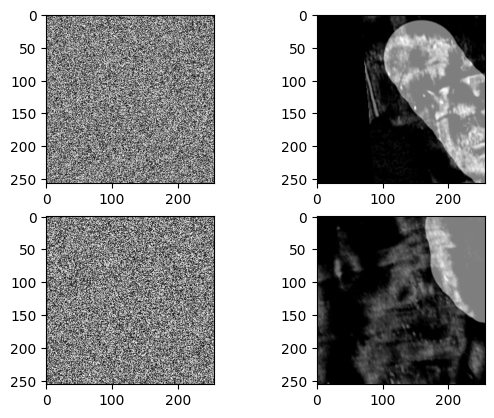


  1%|          | 1/184 [00:32<1:39:51, 32.74s/it]

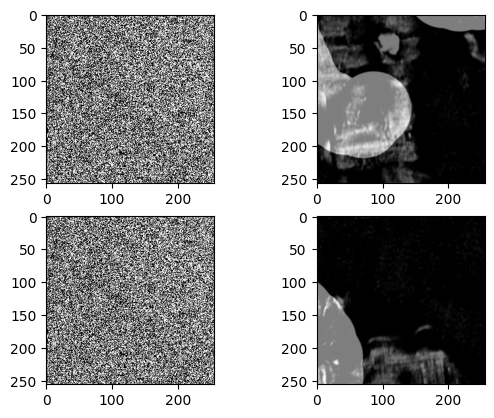


  1%|          | 2/184 [01:05<1:38:55, 32.62s/it]

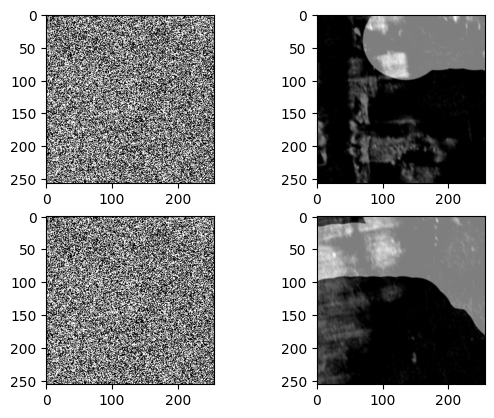


  2%|▏         | 3/184 [01:37<1:37:30, 32.32s/it]

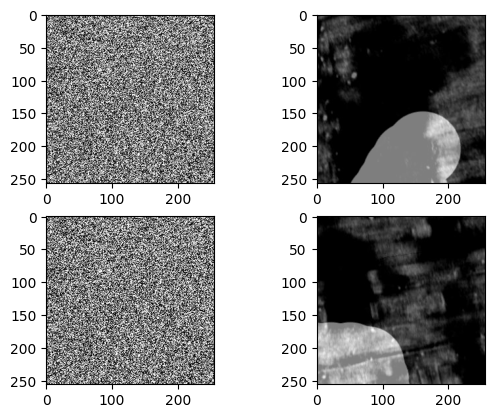


  2%|▏         | 4/184 [02:08<1:36:14, 32.08s/it]

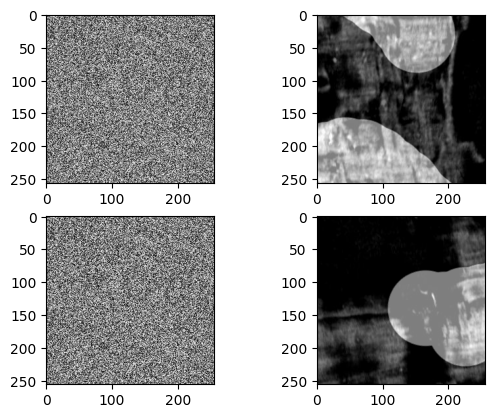


  3%|▎         | 5/184 [02:40<1:35:08, 31.89s/it]

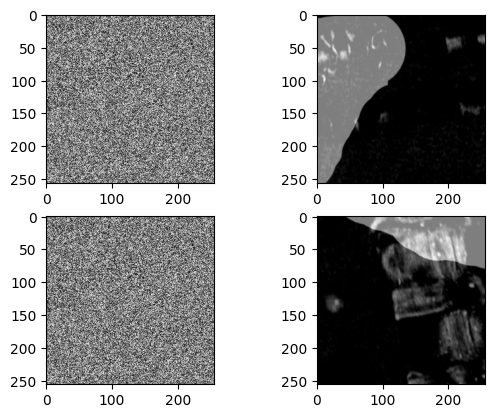


  3%|▎         | 6/184 [03:12<1:34:46, 31.95s/it]

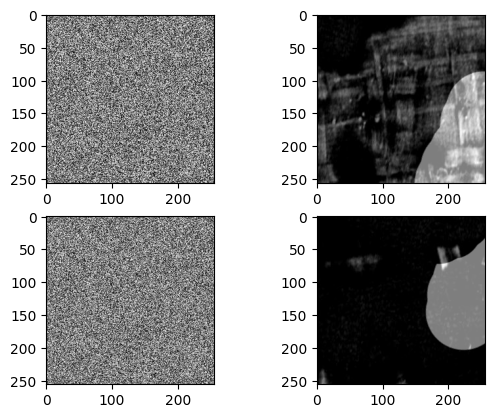


  4%|▍         | 7/184 [03:44<1:34:33, 32.05s/it]

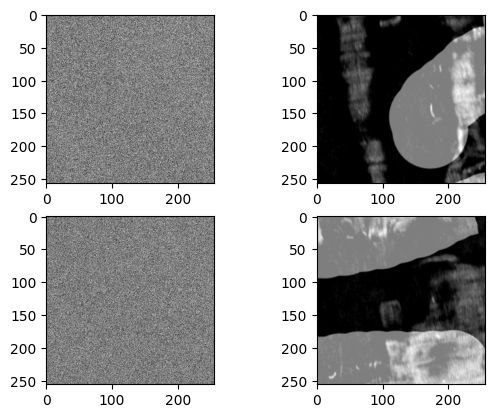


  4%|▍         | 8/184 [04:17<1:34:15, 32.13s/it]

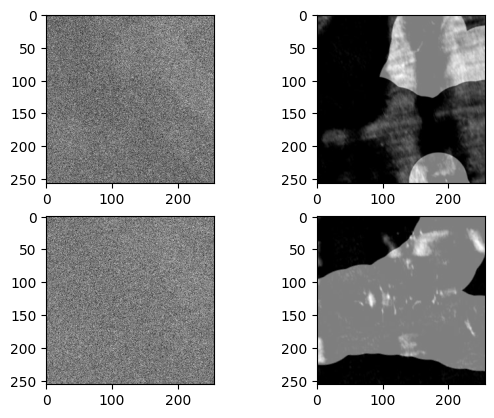


  5%|▍         | 9/184 [04:49<1:33:42, 32.13s/it]

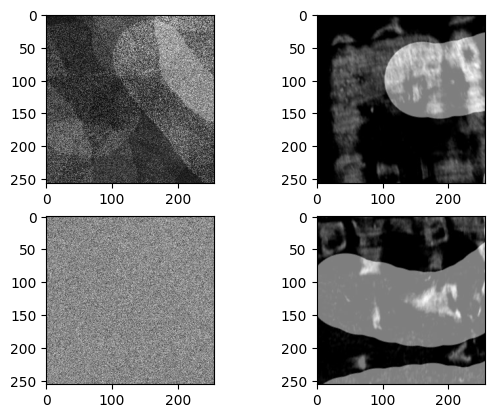


  5%|▌         | 10/184 [05:21<1:33:03, 32.09s/it]

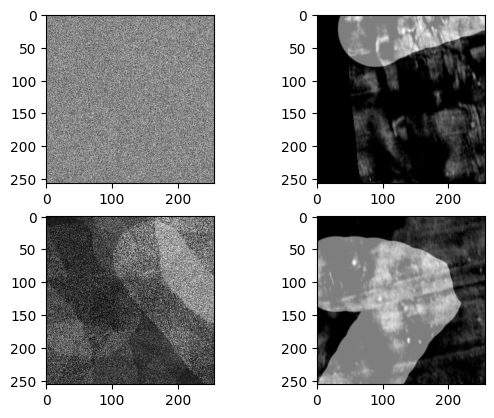


  6%|▌         | 11/184 [05:53<1:32:39, 32.14s/it]

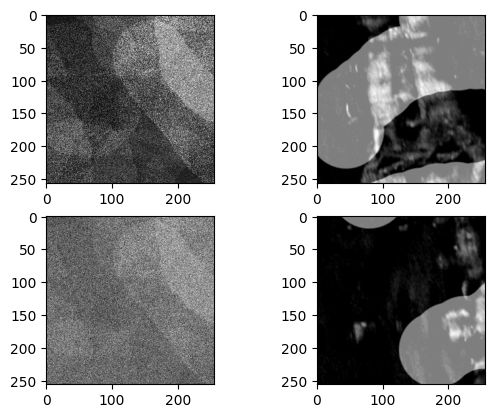


  7%|▋         | 12/184 [06:25<1:31:47, 32.02s/it]

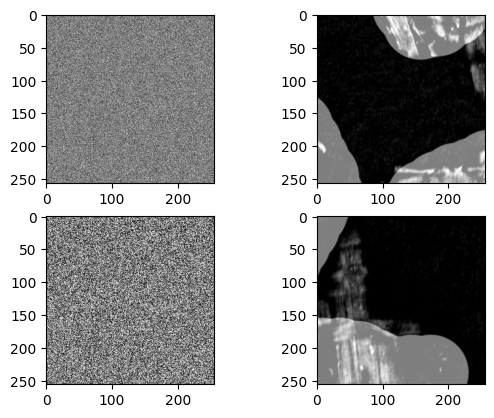


  7%|▋         | 13/184 [06:57<1:31:14, 32.02s/it]

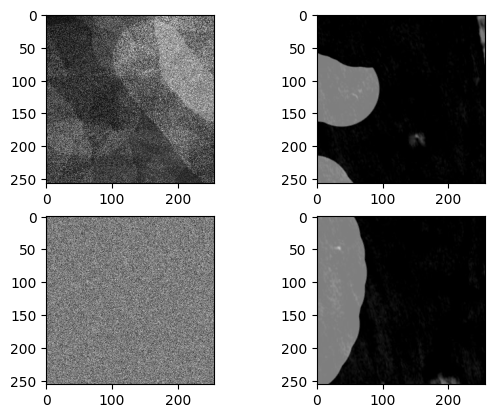


  8%|▊         | 14/184 [07:29<1:30:30, 31.94s/it]

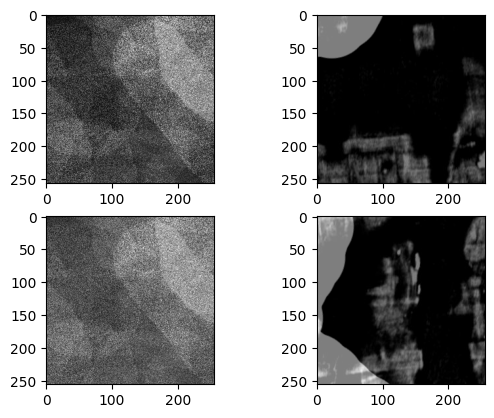


  8%|▊         | 15/184 [08:01<1:30:08, 32.00s/it]

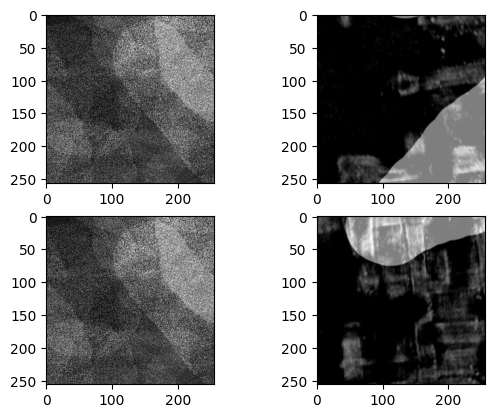


  9%|▊         | 16/184 [08:33<1:29:50, 32.09s/it]

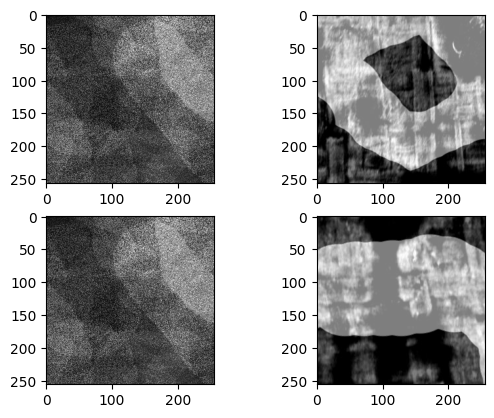


  9%|▉         | 17/184 [09:05<1:29:21, 32.11s/it]

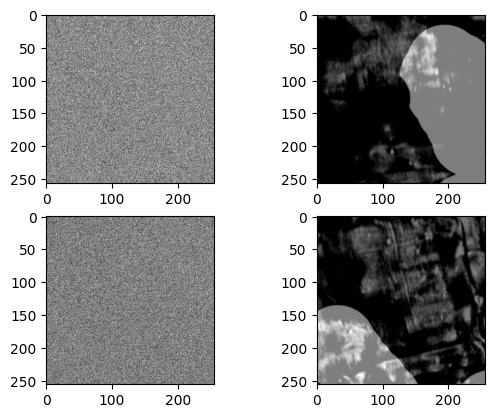


 10%|▉         | 18/184 [09:37<1:28:49, 32.10s/it]

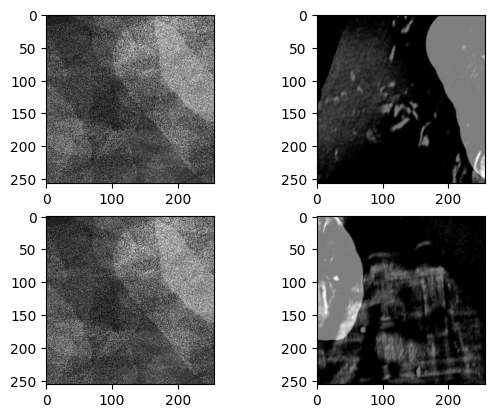


 10%|█         | 19/184 [10:09<1:28:17, 32.11s/it]

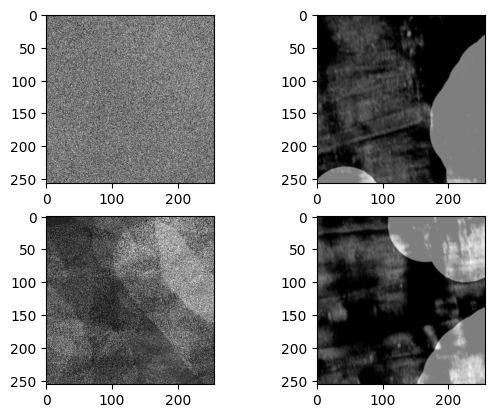


 11%|█         | 20/184 [10:41<1:27:37, 32.06s/it]

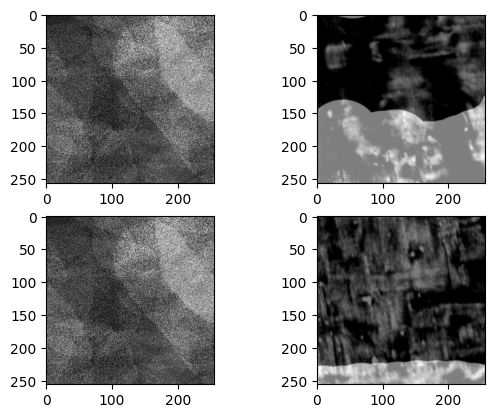


 11%|█▏        | 21/184 [11:14<1:27:55, 32.37s/it]

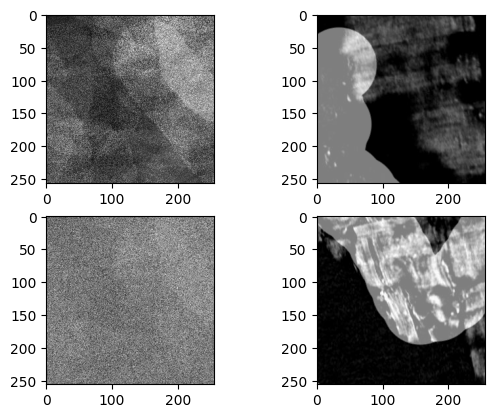


 12%|█▏        | 22/184 [11:46<1:26:59, 32.22s/it]

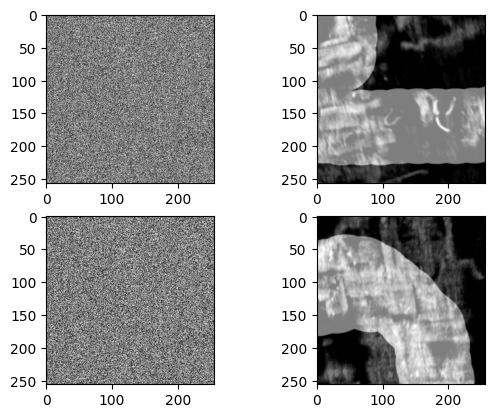


 12%|█▎        | 23/184 [12:18<1:26:16, 32.15s/it]

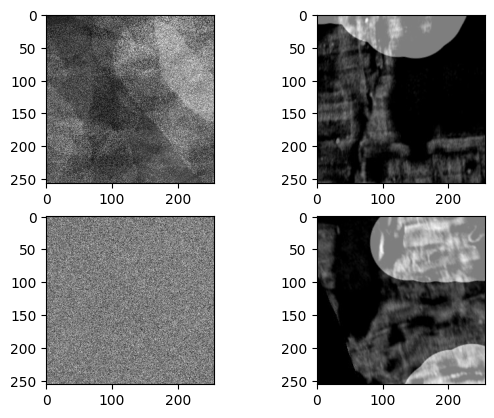


 13%|█▎        | 24/184 [12:50<1:25:42, 32.14s/it]

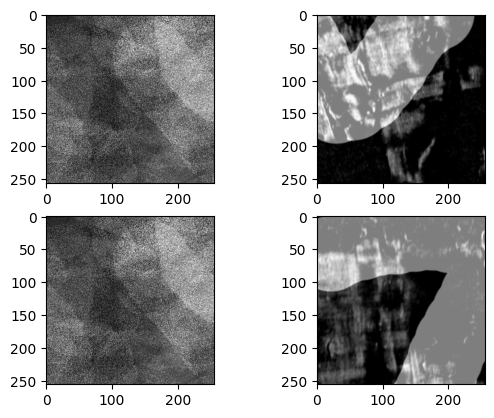


 14%|█▎        | 25/184 [13:22<1:24:55, 32.05s/it]

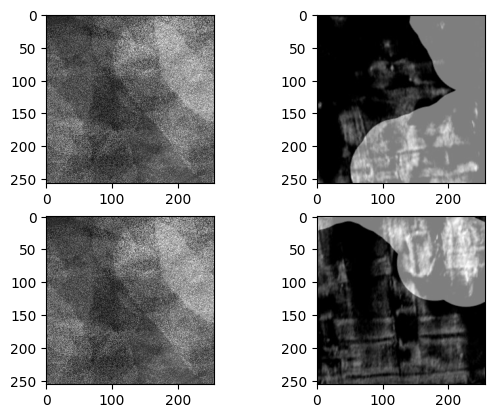


 14%|█▍        | 26/184 [13:54<1:24:27, 32.08s/it]

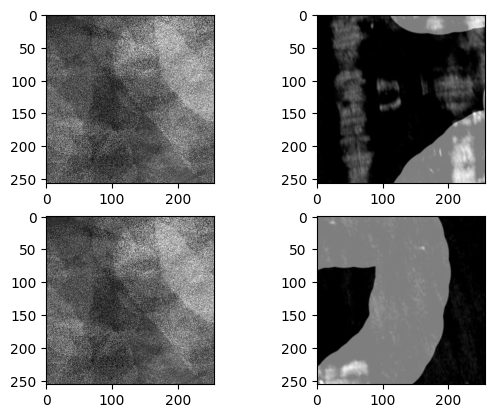


 15%|█▍        | 27/184 [14:26<1:23:46, 32.01s/it]

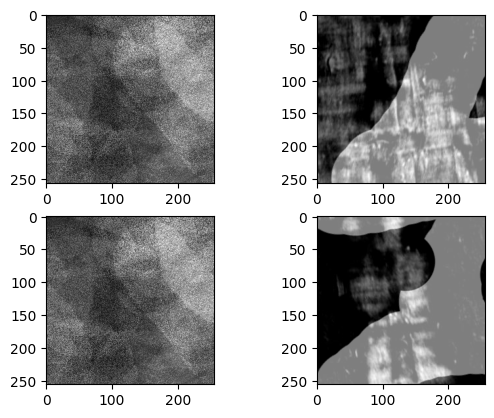


 15%|█▌        | 28/184 [14:58<1:22:53, 31.88s/it]

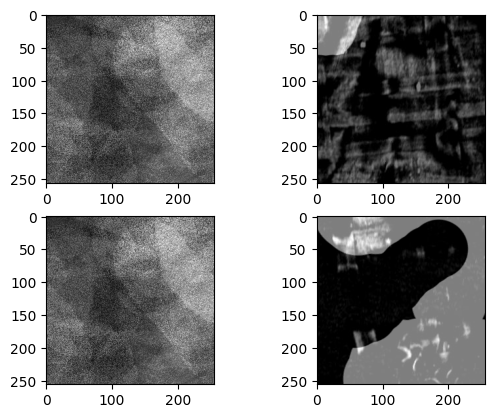


 16%|█▌        | 29/184 [15:30<1:22:19, 31.87s/it]

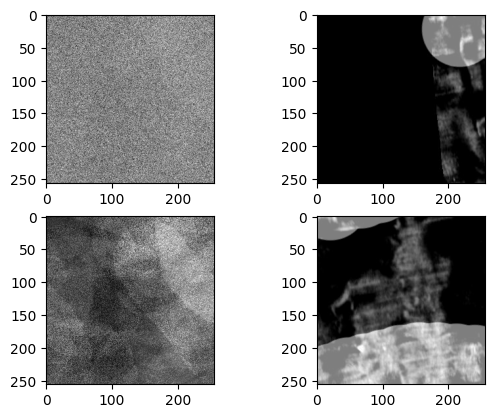


 16%|█▋        | 30/184 [16:01<1:21:35, 31.79s/it]

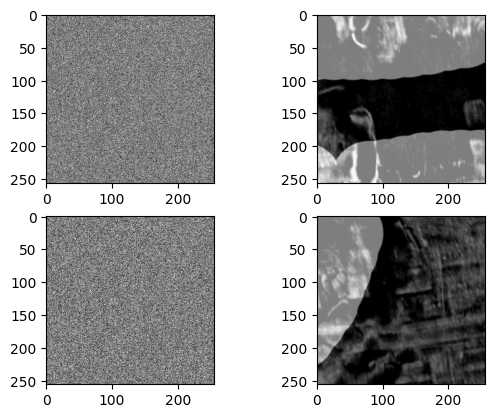


 17%|█▋        | 31/184 [16:33<1:21:15, 31.87s/it]

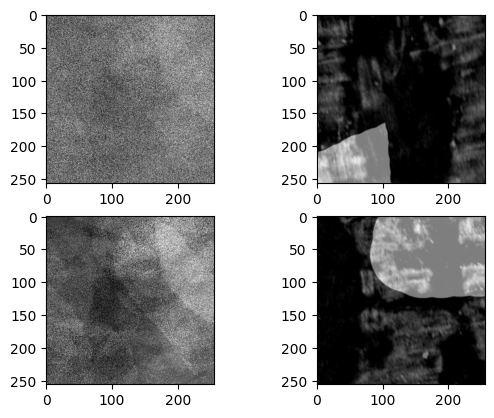


 17%|█▋        | 32/184 [17:05<1:20:23, 31.74s/it]

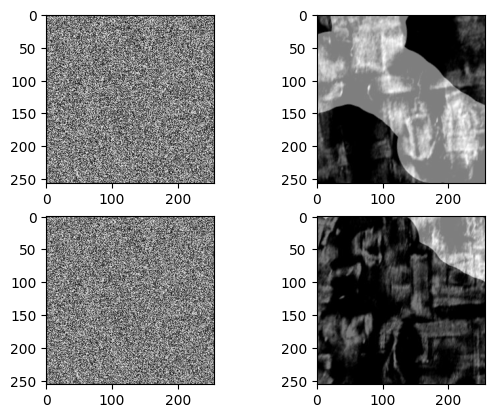


 18%|█▊        | 33/184 [17:36<1:19:55, 31.76s/it]

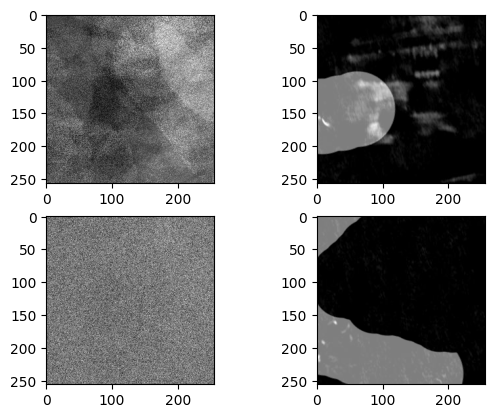


 18%|█▊        | 34/184 [18:08<1:19:09, 31.66s/it]

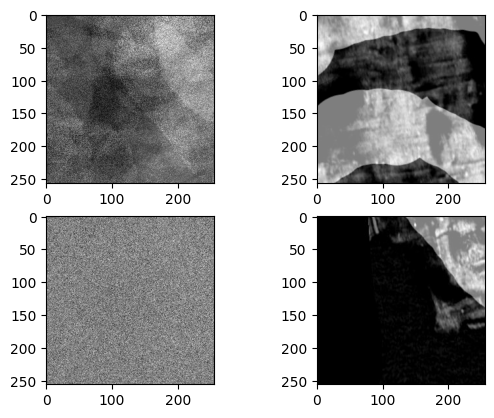


 19%|█▉        | 35/184 [18:39<1:18:31, 31.62s/it]

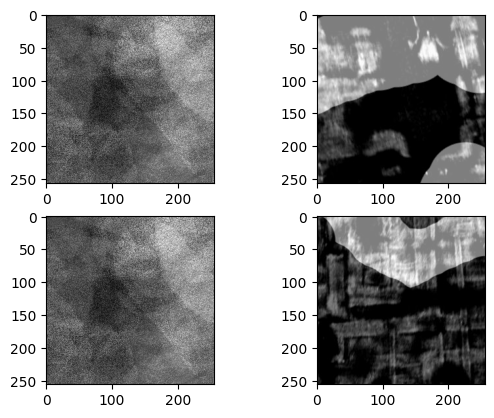


 20%|█▉        | 36/184 [19:11<1:17:49, 31.55s/it]

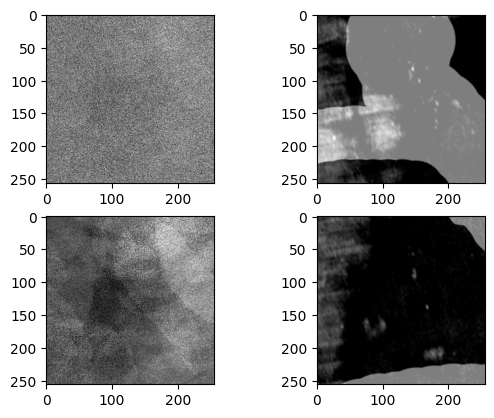


 20%|██        | 37/184 [19:42<1:17:21, 31.58s/it]

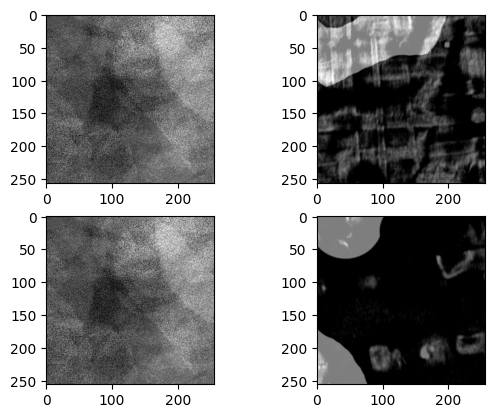


 21%|██        | 38/184 [20:14<1:16:30, 31.44s/it]

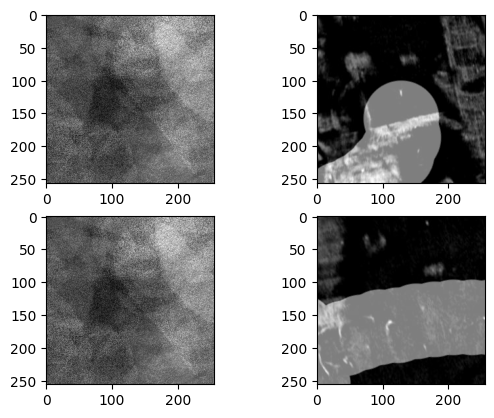


 21%|██        | 39/184 [20:45<1:16:05, 31.49s/it]

In [ ]:
# Define gradient clipping value
from tqdm import tqdm
clip_value = 10.0

model.train()
# Training loop
for epoch in tqdm(range(NUM_EPOCHS)):
    running_loss = 0.0

    for batch_tiles, batch_labels, _ in tqdm(dataloader):
        # Move the data to GPU
        #batch_tiles, batch_labels = batch_tiles.cuda(), batch_labels.float().cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward and backward passes with mixed precision
        #with autocast(device_type=device.type):
            # Forward pass
        outputs = calc_fractal_features(batch_tiles)
        outputs = model(outputs)
        for i in range(outputs.shape[0]):
            plt.subplot(2, 2, 2*i+1)
            plt.imshow(torch.sigmoid(outputs).detach().numpy()[i,0], cmap='gray')
            plt.subplot(2, 2, 2*i+2)
            plt.imshow(batch_tiles[i, 0, -1], cmap='gray')
            plt.imshow(batch_labels.numpy()[i,0], cmap='gray', alpha = 0.5)
        plt.show()
        # Calculate loss
        loss = criterion(outputs, batch_labels)
        # Scale the loss, compute gradients
        loss.backward()
        optimizer.step()

        # Track running loss for the epoch
        running_loss += loss.item()

    # Scheduler step
    scheduler.step()
    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {running_loss/len(dataloader):.4f}')


    if running_loss/len(dataloader) < 0.08:
        print(f"Final loss {running_loss/len(dataloader)}")
        break
print("Training completed.")


In [ ]:
# Initialize predictions and counters with the same shape as the cropped ink label segment
letter_predictions = np.zeros_like(segment.inklabel[200:5600, 1000:4600], dtype=np.float32)
counter_predictions = np.zeros_like(segment.inklabel[200:5600, 1000:4600], dtype=np.float32)

# Set the model to evaluation mode
model.eval()
# Disable gradient calculations for validation to save memory and computations
with torch.no_grad():
    for batch_tiles, batch_labels, corners in valid_dataloader:
        # Move the data and labels to the GPU
        batch_tiles, batch_labels = batch_tiles.cuda(), batch_labels.float().cuda()

        # Forward pass to get model predictions
        with autocast(device_type=device.type):
            outputs = calc_fractal_features(batch_tiles)
            outputs = model(outputs)

        # Apply sigmoid to get probabilities from logits
        predictions = torch.sigmoid(outputs)

        # Process each prediction and update the corresponding regions
        corners = corners.squeeze().cpu().numpy()
        for idx in range(corners.shape[0]):
            x_start, y_start = corners[idx, 0], corners[idx, 1]
            prediction_tile = predictions.cpu().numpy()[idx, 0]  # Convert to NumPy array
            letter_predictions[x_start:x_start + tile_size, y_start:y_start + tile_size] += prediction_tile
            counter_predictions[x_start:x_start + tile_size, y_start:y_start + tile_size] += 1

# Avoid division by zero by setting any zero counts to 1
counter_predictions[counter_predictions == 0] = 1

# Normalize the predictions by the counter values
letter_predictions /= counter_predictions

# Plotting the Ground Truth and Model Predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Ground Truth Label
ax = axes[0]
ax.imshow(segment.inklabel[200:5600, 1000:4600] / 255, cmap='gray')
ax.set_title('Ground Truth Label')
ax.axis('off')

# Add a red rectangle to the ground truth plot
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)

# Model Prediction
ax = axes[1]
ax.imshow(letter_predictions, cmap='gray')
ax.set_title('Model Prediction')
ax.axis('off')

# Add a red rectangle to the prediction plot
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)

# Display the plots
plt.show()


In [ ]:
torch.save(model.state_dict())